This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

In [22]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# Getting started with neural networks: classification and regression

## Classifying movie reviews: a binary classification example

Two-class classification, or binary classification, is one of the most common kinds of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.

### The IMDB dataset

You’ll work with the IMDB dataset: a set of $50,000$ highly polarized reviews from the Internet Movie Database. They’re split into $25,000$ reviews for training and $25,000$ reviews for testing, each set consisting of $50\%$ negative and $50\%$ positive reviews.

**Loading the IMDB dataset**

The argument `num_words=10000` means you’ll only keep the top $10,000$ most frequently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size. If we didn’t set this limit, we’d be working with $88,585$ unique words in the training data, which is unnecessarily large. Many of these words only occur in a single sample, and thus can’t be meaningfully used for classification.

In [47]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000, index_from=3)

In [48]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [49]:
train_labels[0]

1

Because you’re restricting yourself to the top $10,000$ most frequent words, no word index will exceed 10,000:

In [50]:
max([max(sequence) for sequence in train_data])

9999

**Decoding reviews back to text**

In [51]:
# Retrieve the word index file mapping words to indices
word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index.get(i - 3, "?") for i in train_data[0])

In [52]:
decoded_sequence

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### Preparing the data

You can’t directly feed lists of integers into a neural network. They have all different lengths, but a neural network expects to process contiguous batches of data. You have to turn your lists into tensors. There are two ways to do that:

- **Pad** your lists so that they all have the same length, then turn them into an integer tensor of shape (samples, max_length), and start your model with a layer capable of handling such integer tensors (the Embedding layer, which we’ll cover in detail later in the book).
- **Multi-hot encode** your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [8, 5] into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then you could use a Dense layer, capable of handling floating-point vector data, as the first layer in your model.

In [53]:
[len(sentence) for sentence in train_data]

[218,
 189,
 141,
 550,
 147,
 43,
 123,
 562,
 233,
 130,
 450,
 99,
 117,
 238,
 109,
 129,
 163,
 752,
 212,
 177,
 129,
 140,
 256,
 888,
 93,
 142,
 220,
 193,
 171,
 221,
 174,
 647,
 233,
 162,
 597,
 234,
 51,
 336,
 139,
 231,
 704,
 142,
 861,
 132,
 122,
 570,
 55,
 214,
 103,
 186,
 113,
 169,
 469,
 138,
 302,
 766,
 351,
 146,
 59,
 206,
 107,
 152,
 186,
 431,
 147,
 684,
 383,
 324,
 252,
 263,
 787,
 211,
 314,
 118,
 390,
 132,
 710,
 306,
 167,
 115,
 95,
 158,
 156,
 82,
 502,
 314,
 190,
 174,
 60,
 145,
 214,
 659,
 408,
 515,
 461,
 202,
 238,
 170,
 107,
 171,
 158,
 145,
 790,
 258,
 287,
 67,
 123,
 975,
 775,
 236,
 195,
 274,
 214,
 91,
 1038,
 815,
 183,
 206,
 50,
 118,
 147,
 141,
 60,
 56,
 439,
 439,
 213,
 144,
 533,
 303,
 203,
 563,
 129,
 153,
 55,
 92,
 174,
 187,
 183,
 165,
 78,
 198,
 156,
 223,
 127,
 61,
 362,
 84,
 57,
 176,
 159,
 57,
 159,
 165,
 213,
 194,
 149,
 130,
 203,
 19,
 98,
 466,
 525,
 130,
 322,
 153,
 408,
 215,
 472,
 143,
 1

**Encoding the integer sequences via multi-hot encoding**

In [23]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # ith row, and all columns that are actual in the sentence
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [65]:
x_train.shape

(25000, 10000)

In [58]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building your model

The input data is vectors, and the labels are scalars (1s and 0s): this is one of the simplest problem setups you’ll ever encounter. A type of model that performs well on such a problem is a plain stack of densely-connected (Dense) layers with relu activations.

There are two key architecture decisions to be made about such a stack of Dense layers:

- How many layers to use
- How many units to choose for each layer

**Model definition**

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/3_layer_network.png)

The intermediate layers use `relu` as their activation function, and the final layer uses a `sigmoid` activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target "1": how likely the review is to be positive). A `relu` (rectified linear unit) is a function meant to **zero out negative values**, whereas a sigmoid "squashes" arbitrary values into the $[0, 1]$ interval (see figure 4.3), outputting something that can be interpreted as a **probability**.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/The-rectified-linear-unit-function.png)

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/The-sigmoid-function.png)

In [59]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

**Compiling the model**

In [60]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [67]:
shuffled_index = np.random.permutation(range(x_train.shape[0]))

x_val = x_train[shuffled_index][:10000]
partial_x_train = x_train[shuffled_index][10000:]
y_val = y_train[shuffled_index][:10000]
partial_y_train = y_train[shuffled_index][10000:]

**Training your model**

In [68]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 22ms/step - loss: 0.5327 - accuracy: 0.7833 - val_loss: 0.4029 - val_accuracy: 0.8642
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3181 - accuracy: 0.8995 - val_loss: 0.3190 - val_accuracy: 0.8828
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2284 - accuracy: 0.9295 - val_loss: 0.2903 - val_accuracy: 0.8865
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1788 - accuracy: 0.9430 - val_loss: 0.2890 - val_accuracy: 0.8865
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1421 - accuracy: 0.9575 - val_loss: 0.2981 - val_accuracy: 0.8830
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1176 - accuracy: 0.9651 - val_loss: 0.3283 - val_accuracy: 0.8784
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0961 - accuracy: 0.9727 - val_loss: 0.3480 - val_accuracy: 0.8762
Epoch 8/20
30/30 

In [69]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Plotting the training and validation loss**

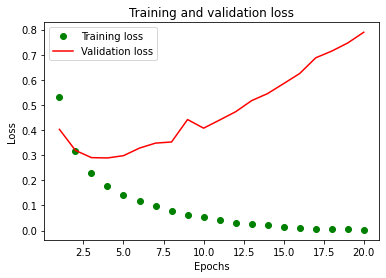

In [73]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "og", label="Training loss")
plt.plot(epochs, val_loss_values, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

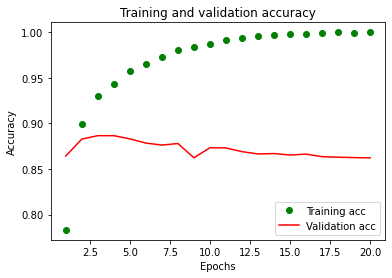

In [74]:
plt.clf()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "go", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That’s what you would expect when running gradient-descent optimization—the quantity you’re trying to minimize should be less with every iteration. But that isn’t the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. In precise terms, what you’re seeing is **overfitting**: after the fourth epoch, you’re over-optimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

**Retraining a model from scratch**

In [76]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test, return_dict=True)

Epoch 1/4
49/49 [==============================] - 1s 6ms/step - loss: 0.4915 - accuracy: 0.8150
Epoch 2/4
49/49 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.90 - 0s 6ms/step - loss: 0.2823 - accuracy: 0.9049
Epoch 3/4
49/49 [==============================] - 0s 6ms/step - loss: 0.2116 - accuracy: 0.9264
Epoch 4/4
782/782 [==============================] - 25s 31ms/step - loss: 0.2926 - accuracy: 0.8843


In [77]:
results

{'loss': 0.29259607195854187, 'accuracy': 0.8842800259590149}

### Using a trained model to generate predictions on new data

In [78]:
model.predict(x_test)

array([[0.16073775],
       [0.99819577],
       [0.8550322 ],
       ...,
       [0.09465057],
       [0.06173232],
       [0.5093109 ]], dtype=float32)

### Further experiments

The following experiments will help convince you that the architecture choices you’ve made are all fairly reasonable, although there’s still room for improvement:

- You used two representation layers before the final classification layer. Try using one or three representation layers, and see how doing so affects validation and test accuracy.
- Try using layers with more units or fewer units: $32$ units, $64$ units, and so on.
- Try using the `mse` loss function instead of `binary_crossentropy`.
- Try using the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

### Wrapping up

- You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options, too.
- Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you’ll likely use them frequently.
- In a binary classification problem (two output classes), your model should end with a `Dense` layer with one unit and a `sigmoid` activation: the output of your model should be a scalar between $0$ and $1$, encoding a probability.
- With such a scalar `sigmoid` output on a binary classification problem, the loss function you should use is `binary_crossentropy`.
- The `rmsprop` optimizer is generally a good enough choice, whatever your problem. That’s one less thing for you to worry about.
- As they get better on their training data, neural networks eventually start **overfitting** and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set.

## Classifying newswires: a multiclass classification example

### The Reuters dataset

In this section, you’ll build a model to classify Reuters newswires into $46$ mutually exclusive topics. Because you have many classes, this problem is an instance of **multiclass classification**; and because each data point should be classified into only one category, the problem is more specifically an instance of **single-label, multiclass classification**. If each data point could belong to multiple categories (in this case, topics), you’d be facing a multilabel, multiclass classification problem.

You’ll work with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There are $46$ different topics; some topics are more represented than others, but each topic has at least $10$ examples in the training set.

**Loading the Reuters dataset**

In [4]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

C:\tools\miniconda3\envs\dl\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\tools\miniconda3\envs\dl\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [5]:
len(train_data)

8982

In [6]:
len(test_data)

2246

In [7]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

**Decoding newswires back to text**

In [8]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])

In [9]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [10]:
train_labels[10]

3

### Preparing the data

**Encoding the input data**

In [11]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**Encoding the labels**

To vectorize the labels, there are two possibilities: you can cast the label list as an integer tensor, or you can use one-hot encoding. **One-hot encoding** is a widely used format for categorical data, also called categorical encoding.In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index. Here’s an example:

In [12]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [13]:
y_train.shape

(8982, 46)

In [14]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Building your model

**Model definition**

There are two other things you should note about this architecture:

You end the model with a `Dense` layer of size $46$. This means for each input sample, the network will output a $46$-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.

The last layer uses a `softmax` activation. You saw this pattern in the MNIST example. It means the model will output a **probability distribution over the $46$ different output classes**—for every input sample, the model will produce a $46$-dimensional output vector, where `output[i]` is the probability that the sample belongs to class $i$. The $46$ scores will sum to $1$.


In [24]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

**Compiling the model**

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: here, between the probability distribution output by the model and the true distribution of the labels. By minimizing the distance between these two distributions, you train the model to output something as close as possible to the true labels.

In [25]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [18]:
shuffled_index = np.random.permutation(range(x_train.shape[0]))

x_val = x_train[shuffled_index][:1000]
partial_x_train = x_train[shuffled_index][1000:]
y_val = y_train[shuffled_index][:1000]
partial_y_train = y_train[shuffled_index][1000:]

**Training the model**

In [19]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 24ms/step - loss: 2.6813 - accuracy: 0.5119 - val_loss: 1.7369 - val_accuracy: 0.6430
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 1.4278 - accuracy: 0.6964 - val_loss: 1.2834 - val_accuracy: 0.7230
Epoch 3/20
16/16 [==============================] - 0s 13ms/step - loss: 1.0427 - accuracy: 0.7740 - val_loss: 1.1270 - val_accuracy: 0.7520
Epoch 4/20
16/16 [==============================] - 0s 11ms/step - loss: 0.8159 - accuracy: 0.8232 - val_loss: 1.0416 - val_accuracy: 0.7700
Epoch 5/20
16/16 [==============================] - 0s 13ms/step - loss: 0.6473 - accuracy: 0.8633 - val_loss: 0.9972 - val_accuracy: 0.7840
Epoch 6/20
16/16 [==============================] - 0s 12ms/step - loss: 0.5137 - accuracy: 0.8920 - val_loss: 0.9388 - val_accuracy: 0.7950
Epoch 7/20
16/16 [==============================] - 0s 12ms/step - loss: 0.4068 - accuracy: 0.9143 - val_loss: 0.9348 - val_accuracy: 0.8010
Epoch 8/20
16

**Plotting the training and validation loss**

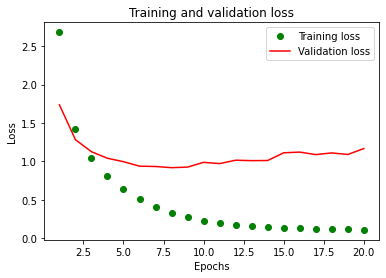

In [26]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "go", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

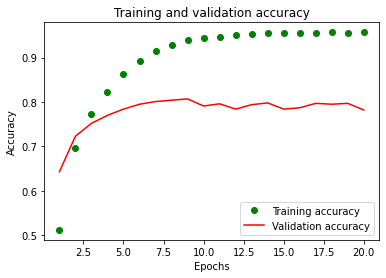

In [27]:
plt.clf()

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "go", label="Training accuracy")
plt.plot(epochs, val_acc, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [28]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test, return_dict=True)

Epoch 1/9
18/18 [==============================] - 1s 9ms/step - loss: 2.4859 - accuracy: 0.5603
Epoch 2/9
18/18 [==============================] - 0s 10ms/step - loss: 1.3175 - accuracy: 0.7196
Epoch 3/9
18/18 [==============================] - 0s 11ms/step - loss: 0.9841 - accuracy: 0.7859
Epoch 4/9
18/18 [==============================] - 0s 9ms/step - loss: 0.7763 - accuracy: 0.8334
Epoch 5/9
18/18 [==============================] - 0s 10ms/step - loss: 0.6118 - accuracy: 0.8732
Epoch 6/9
18/18 [==============================] - 0s 9ms/step - loss: 0.4904 - accuracy: 0.8988
Epoch 7/9
18/18 [==============================] - 0s 9ms/step - loss: 0.3926 - accuracy: 0.9171
Epoch 8/9
18/18 [==============================] - 0s 9ms/step - loss: 0.3210 - accuracy: 0.9309
Epoch 9/9
71/71 [==============================] - 2s 32ms/step - loss: 0.9537 - accuracy: 0.7921


In [29]:
results

{'loss': 0.9536892771720886, 'accuracy': 0.7920747995376587}

This approach reaches an accuracy of ~$80\%$. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be $50\%$. But in this case, we have $46$ classes, and they may not be equally represented. What would be the accuracy of a random baseline? We could try quickly implementing one to check this empirically:

In [30]:
import copy

hits_array = np.random.permutation(test_labels) == np.array(test_labels)
hits_array.mean()

0.1651825467497774

### Generating predictions on new data

In [31]:
predictions = model.predict(x_test)

In [32]:
predictions[0].shape

(46,)

In [33]:
np.sum(predictions[0])

1.0000001

In [34]:
np.argmax(predictions[0])

3

### A different way to handle the labels and the loss

The only thing this approach would change is the choice of the loss function. The loss function `categorical_crossentropy`, expects the labels to follow a categorical encoding. With integer labels, you should use `sparse_categorical_crossentropy`:

In [35]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [39]:
y_train.shape

(8982,)

In [41]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### The importance of having sufficiently large intermediate layers

We mentioned earlier that because the final outputs are $46$-dimensional, you should avoid intermediate layers with many fewer than $46$ units. Now let’s see what happens when you introduce an information bottleneck by having intermediate layers that are significantly less than $46$-dimensional: for example, 4-dimensional.

**A model with an information bottleneck**

In [43]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),  # information bottlenack
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 24ms/step - loss: 3.0718 - accuracy: 0.2722 - val_loss: 2.4650 - val_accuracy: 0.4220
Epoch 2/20
63/63 [==============================] - 1s 22ms/step - loss: 2.0874 - accuracy: 0.4545 - val_loss: 1.9415 - val_accuracy: 0.4430
Epoch 3/20
63/63 [==============================] - 1s 22ms/step - loss: 1.6674 - accuracy: 0.4894 - val_loss: 1.5998 - val_accuracy: 0.5840
Epoch 4/20
63/63 [==============================] - 1s 18ms/step - loss: 1.3439 - accuracy: 0.6537 - val_loss: 1.3945 - val_accuracy: 0.6380
Epoch 5/20
63/63 [==============================] - 1s 22ms/step - loss: 1.1773 - accuracy: 0.6973 - val_loss: 1.3437 - val_accuracy: 0.6720
Epoch 6/20
63/63 [==============================] - 1s 23ms/step - loss: 1.0704 - accuracy: 0.7286 - val_loss: 1.3441 - val_accuracy: 0.6790
Epoch 7/20
63/63 [==============================] - 1s 21ms/step - loss: 0.9973 - accuracy: 0.7390 - val_loss: 1.3311 - val_accuracy: 0.6850
Epoch 8/20
63

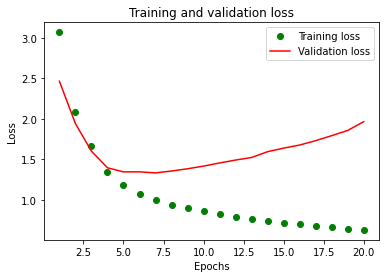

In [44]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "go", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

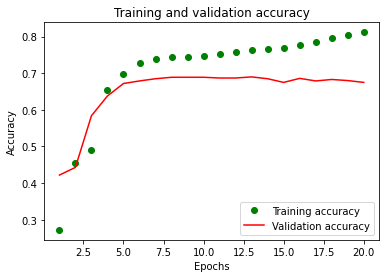

In [45]:
plt.clf()

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "go", label="Training accuracy")
plt.plot(epochs, val_acc, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Further experiments

- Try using larger or smaller layers: 32 units, 128 units, and so on.
- You used two intermediate layers before the final softmax classification layer. Now try using a single intermediate layer, or three intermediate layers.

### Wrapping up

Here’s what you should take away from this example:

- If you’re trying to classify data points among $N$ classes, your model should end with a `Dense` layer of size $N$.
- In a single-label, multiclass classification problem, your model should end with a `softmax` activation so that it will output a **probability distribution** over the $N$ output classes.
- **Categorical crossentropy** is almost always the **loss function** you should use for such problems. It __minimizes the distance between the probability distributions__ output by the model and the true distribution of the targets.
- There are two ways to handle labels in multiclass classification:
   - Encoding the labels via **categorical encoding** (also known as **one-hot encoding**) and using `categorical_crossentropy` as a loss function
   - Encoding the labels as **integers** and using the `sparse_categorical_crossentropy` loss function
- If you need to classify data into a large number of categories, you should avoid creating **information bottlenecks** in your model due to intermediate layers that are too small.

## Predicting house prices: a regression example

The two previous examples were considered **classification problems**, where the goal was to predict a single discrete label of an input data point. Another common type of machine-learning problem is **regression**, which consists of predicting a continuous value instead of a discrete label: for instance, predicting the temperature tomorrow, given meteorological data; or predicting the time that a software project will take to complete, given its specifications.

### The Boston Housing Price dataset

You’ll attempt to **predict the median price of homes in a given Boston suburb** in the mid-1970s, given data points about the suburb at the time, such as the `crime rate`, the local `property tax rate`, and so on. The dataset you’ll use has an interesting difference from the two previous examples. It has relatively few data points: only $506$, split between $404$ training samples and $102$ test samples. And each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between $0$ and $1$; others take values between $1$ and $12$, others between $0$ and $100$, and so on.

**Loading the Boston housing dataset**

In [105]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [106]:
from sklearn.datasets import load_boston

load_boston()

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [107]:
train_data.shape

(404, 13)

In [108]:
test_data.shape

(102, 13)

In [109]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

(array([ 15.,  48.,  72., 120.,  64.,  31.,  21.,   8.,   8.,  17.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <BarContainer object of 10 artists>)

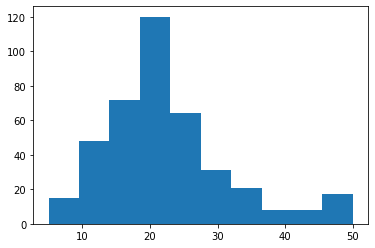

In [110]:
plt.hist(train_targets)

The prices are typically between $\$10,000$ and $\$50,000$. If that sounds cheap, remember that this was the mid-1970s, and these prices aren’t adjusted for inflation.

### Preparing the data

**Normalizing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do **feature-wise normalization**

Note that the quantities used for normalizing the test data are computed using the **training data**. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.

In [111]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

Because so few samples are available, you’ll use a very small model with two intermediate layers, each with $64$ units. In general, the less training data you have, the worse overfitting will be, and using a small model is one way to mitigate overfitting.

**Model definition**

The model ends with a **single unit and no activation** (it will be a linear layer). This is a typical setup for **scalar regression** (a regression where you’re trying to predict a single continuous value). Applying an activation function would constrain the range the output can take; for instance, if you applied a `sigmoid` activation function to the last layer, the model could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the model is free to learn to predict values in any range.

Note that you compile the model with the `mse` loss function — mean squared error, the square of the difference between the predictions and the targets. This is a widely used loss function for regression problems.

You’re also monitoring a new metric during training: **mean absolute error** (MAE). It’s the absolute value of the difference between the predictions and the targets. For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average.


In [62]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

To evaluate your model while you keep adjusting its parameters (such as the number of epochs used for training), you could split the data into a training set and a validation set, as you did in the previous examples. But because you have so few data points, the validation set would end up being very small (for instance, about 100 examples). As a consequence, the validation scores might change a lot depending on which data points you chose to use for validation and which you chose for training: the validation scores might have a high variance with regard to the validation split. This would prevent you from reliably evaluating your model.

The best practice in such situations is to use **K-fold cross-validation** (see figure 4.8). It consists of splitting the available data into $K$ partitions (typically K = 4 or 5), instantiating $K$ identical models, and training each one on $K – 1$ partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the $K$ validation scores obtained. In terms of code, this is straightforward.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/3-fold-cross-validation.png)

**K-fold validation**

In [112]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [115]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=k)
all_scores = []
for train_index, val_index in kf.split(train_data, train_targets):
    val_data, val_targets = train_data[val_index], train_targets[val_index]
    partial_train_data, partial_train_targets = train_data[train_index], train_targets[train_index]
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)   
    
    

In [116]:
all_scores

[2.066729784011841, 2.31536602973938, 2.6480789184570312, 2.422050952911377]

In [117]:
np.mean(all_scores)

2.3630564212799072

**Saving the validation logs at each fold**

In [118]:
num_epochs = 500

all_mae_histories = []
for train_index, val_index in kf.split(train_data):
    val_data, val_targets = train_data[val_index], train_targets[val_index]
    partial_train_data, partial_train_targets = train_data[train_index], train_targets[train_index]
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

**Building the history of successive mean K-fold validation scores**

In [119]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

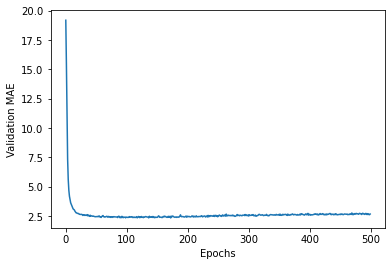

In [120]:
plt.plot(average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

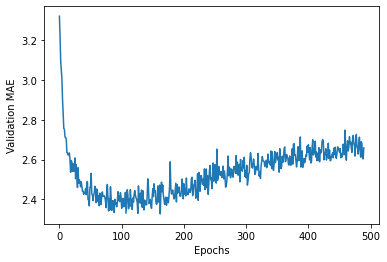

In [121]:
truncated_mae_history = average_mae_history[10:]
plt.plot(truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

Once you’re finished tuning other parameters of the model (in addition to the number of epochs, you could also adjust the size of the intermediate layers), you can train a final production model on all of the training data, with the best parameters, and then look at its performance on the test data.

In [122]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 14.7815 - mae: 2.5467


In [123]:
test_mae_score

2.5467073917388916

You’re still off by about $\$2,500$.

### Generating predictions on new data

In [124]:
predictions = model.predict(test_data)
predictions[0]

array([8.31038], dtype=float32)

### Wrapping up

Here’s what you should take away from this scalar regression example:

- Regression is done using different loss functions than what we used for classification. **Mean squared error** (MSE) is a loss function commonly used for regression.
- Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is **mean absolute error** (MAE).
- When features in the input data have values in different ranges, each feature should be **scaled independently** as a preprocessing step.
- When there is little data available, using **K-fold cross-validation** is a great way to reliably evaluate a model.
- When little training data is available, it’s preferable to use a small model with **few intermediate layers** (typically only one or two), in order to avoid severe overfitting.


## Chapter summary

- The three most common kinds of machine-learning tasks on vector data are **binary classification, multiclass classification, and scalar regression**.
- You’ll usually need to preprocess raw data before feeding it into a neural network.
- When your data has features with different ranges, scale each feature independently as part of preprocessing.
- As training progresses, neural networks eventually begin to overfit and obtain worse results on never-before-seen data.
- If you don’t have much training data, use a small model with only one or two intermediate layers, to avoid severe overfitting.
- If your data is divided into many categories, you may cause information bottlenecks if you make the intermediate layers too small.
- When you’re working with little data, K-fold validation can help reliably evaluate your model